In [1]:
import tensorflow as tf
import keras
import keras.layers as lay
import numpy as np
import matplotlib.pyplot as plt
import src.generator as gen_fun

In [2]:
generator = gen_fun.Generator(input_shape=(128,))
signal = tf.random.normal((1,128),0,1)

(1, 32, 32, 3)


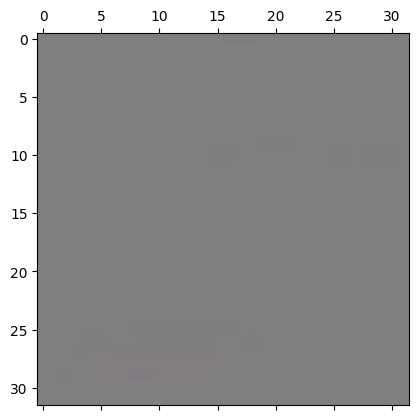

In [11]:
out = generator(signal,resolution=32,fade=0)
print(out.shape)
plt.matshow(np.uint8(out[0]*127.5+127.5))
plt.show()